## Fraud Data Analysis
This notebook examines the fraud probability data, and estimates fraud probability for Feb 2022 onwards, where none were provided
### Load constants and libraries
First of all we load any constant values for use within the notebook, load any libraries required, and initiate a spark object. 

In [1]:
# import all constants and custome functions used in the note books
import sys
sys.path.append('../scripts/utils')
from constants import *
from custom_functions import *


# libraries required
import os
from pyspark.sql import functions as F
from pyspark.sql import SparkSession
from pyspark.sql import DataFrame
import pandas as pd
import re
from typing import Callable
import datetime

from scipy import stats
from statsmodels.formula.api import ols
import statsmodels.api as sm
import numpy as np
import matplotlib.pyplot as plt
import math

# plot configuration
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 12}

plt.rc('font', **font)
plt.rcParams["axes.labelweight"] = "normal"
plt.rcParams["axes.titleweight"] = "normal"

# Create a spark session (which will run spark jobs)
spark = (
    SparkSession.builder.appName("MAST30034 Project 2")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config('spark.driver.memory', '4g')
    .config('spark.executor.memory', '2g')
    .getOrCreate()
)

your 131072x1 screen size is bogus. expect trouble
23/10/20 09:00:51 WARN Utils: Your hostname, DESKTOP-VP2PCTV resolves to a loopback address: 127.0.1.1; using 172.21.252.215 instead (on interface eth0)
23/10/20 09:00:51 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/10/20 09:00:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


### Consumer Fraud Probability
Inspect the consumer fraud probability in order to derive a model to fill missing data.

To start off with examine the individual transaction data

In [2]:
# load up the consumer fraud data and map to transactions
transaction_data = spark.read.parquet(f'{TRANSACTION_DATA}')
print(f'number of user_ids in the transaction data {transaction_data.select("user_id").distinct().count()}')
consumer_fraud = spark.createDataFrame(pd.read_pickle(f"{CURATED_DATA}consumer_fraud_probability.pkl"))
#consumer_fraud_transactions = transaction_data.join(consumer_fraud, on=["user_id", "order_datetime"], how="inner")
print(f'number of user_ids in the fraud data {consumer_fraud.select("user_id").distinct().count()}')

# tally total traded and number of transactions, per user, per day
consumer_fraud_daily = transaction_data.groupBy(["user_id", "order_datetime"]).agg(
    F.count(F.col("order_id")).alias("num_orders"),
    F.sum(F.col("dollar_value")).alias("total_spending") 
)
consumer_fraud_daily = consumer_fraud_daily.join(consumer_fraud, on=["user_id", "order_datetime"], how="inner")

number of user_ids in the transaction data 24081


number of user_ids in the fraud data 20128


In [3]:
# checking that consumers are always given the same fraud probability score on the same day, even if they have multiple lines in the consumer_fraud data
fraud_sd_daily = transaction_data.join(consumer_fraud, on=["user_id", "order_datetime"], how="inner").\
    groupBy(["user_id", "order_datetime"]).agg(      
        F.stddev(F.col("fraud_probability")).alias("fraud_stdev")    
    )

print('checking the maximum standard deviation is zero for all users, for transactions on the same day, means that users attract the same fraud score on any given day')
print(fraud_sd_daily.select(F.max(fraud_sd_daily.fraud_stdev)==0))

checking the maximum standard deviation is zero for all users, for transactions on the same day, means that users attract the same fraud score on any given day


+----------------------+
|(max(fraud_stdev) = 0)|
+----------------------+
|                  true|
+----------------------+



We have shown that user fraud probability is the same for all transcations for a particular user, on any one day. Next we aggregate the user transaction data on a daily basis, and see if the fraud probability changes over time. To do that we will look at standard deviations once again, in terms of fraud probability and total spending (this time between different days, rather than within a single day)

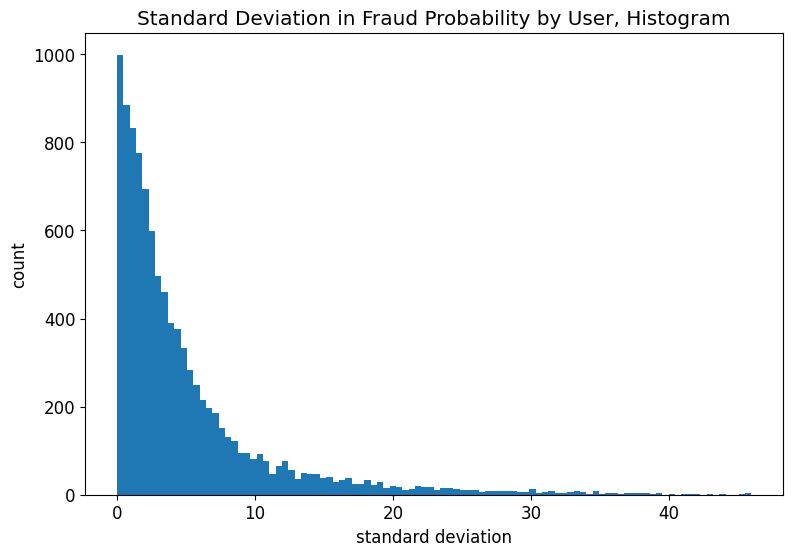

In [4]:
# calculate standard deviations per user, across time, for fraud_probability and total spending
fraud_sd_daily = consumer_fraud_daily.groupby(['user_id']).agg(
    F.stddev(F.col("fraud_probability")).alias("fraud_st_dev"),
    F.stddev(F.col("total_spending")).alias("spending_st_dev"),
    F.count(F.col("order_datetime")).alias("num_daily_trades")
)
   
# filter to users that have traded across at least two days to see how fraud probability changes
fraud_sd_daily = fraud_sd_daily[fraud_sd_daily.num_daily_trades>1]
fraud_sd_daily = fraud_sd_daily.toPandas()

# check how common it is for fraud probability to move over time, per user, by plotting the standard deviation of fraud probability by user
# a lot of the time the fraud probability by user is constant, but it does move, need to understand what drives this

ax = fraud_sd_daily['fraud_st_dev'].plot.hist(    
    title = 'Standard Deviation in Fraud Probability by User, Histogram', 
    ylabel='count',
    bins=100)

ax.set_xlabel("standard deviation")
fig = ax.get_figure()
fig.set_size_inches(9, 6)


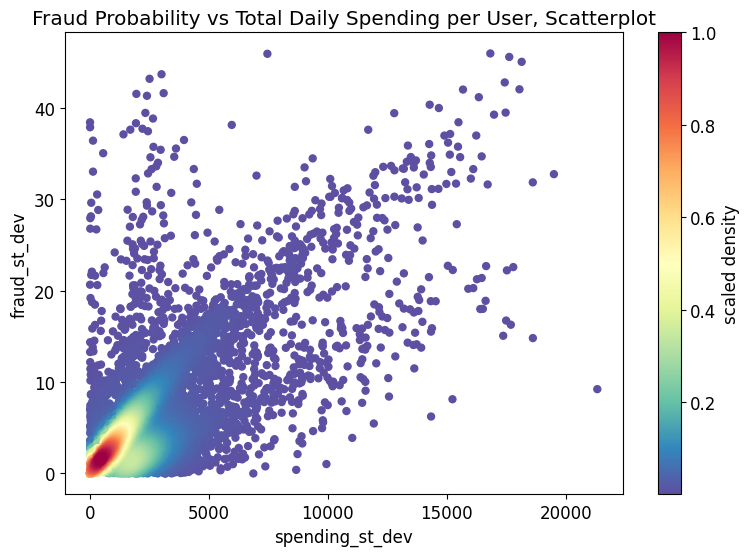

In [5]:
# next we plot the standard deviation of fraud probability versus the standard deviation in total spending 
scatter_daily = scatter_density(fraud_sd_daily, 'spending_st_dev', 'fraud_st_dev', 'Fraud Probability vs Total Daily Spending per User, Scatterplot')
del fraud_sd_daily

It can be seen that variability in spending drives variability in fraud probability, so it makes sense to examine if fraud probability is closely related to the level of spending on any given day. We will also take a look at number of trades in a day, as a potential driver

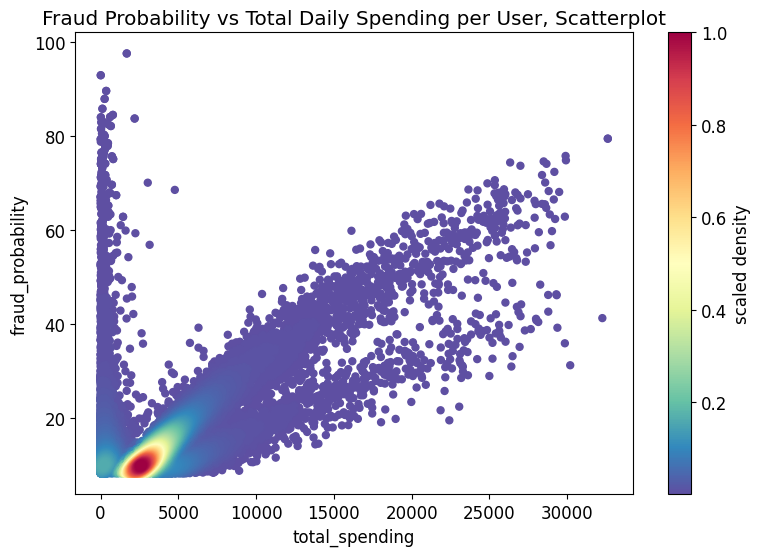

In [6]:
consumer_fraud_daily = consumer_fraud_daily.toPandas()
consumer_fraud_daily["order_datetime"] = pd.to_datetime(consumer_fraud_daily["order_datetime"], format='%Y-%m-%d')

# remove single outlier
consumer_fraud_daily = consumer_fraud_daily[consumer_fraud_daily["total_spending"]<50000]

# plot fraud probability against total spending, per user, per day
scatter_daily = scatter_density(consumer_fraud_daily, 'total_spending', 'fraud_probability', 'Fraud Probability vs Total Daily Spending per User, Scatterplot')

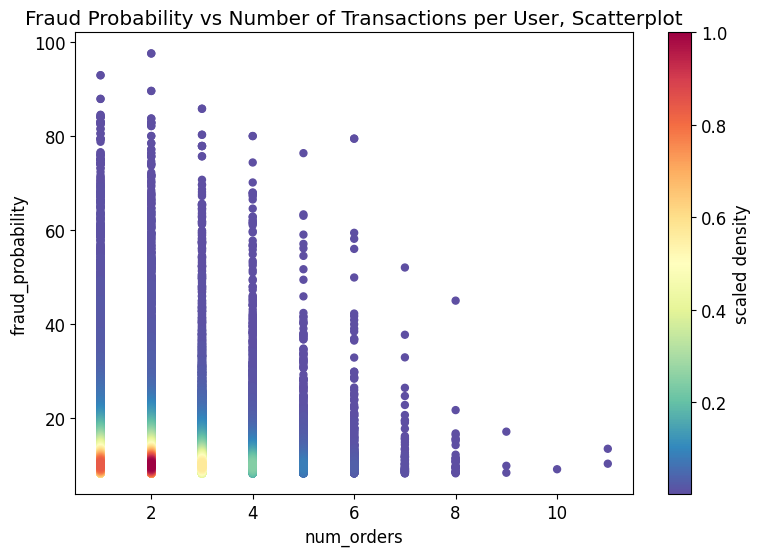

In [7]:
# checking fraud probability against number of transactions, per user, per day, no discernible relationship here

scatter_num_trades = scatter_density(consumer_fraud_daily, 'num_orders', 'fraud_probability', 'Fraud Probability vs Number of Transactions per User, Scatterplot')

It looks like there is a meaningful relationship between total spending and fraud probability, but this perhaps reflects a mixture of three underlying models. This needs to be explored.


number transactions Feb 2021 to Aug 2021: 3493963
number transactions Sep 2021 to Feb 2022: 4323607
number transactions Feb 2022 to Aug 2022: 5796843


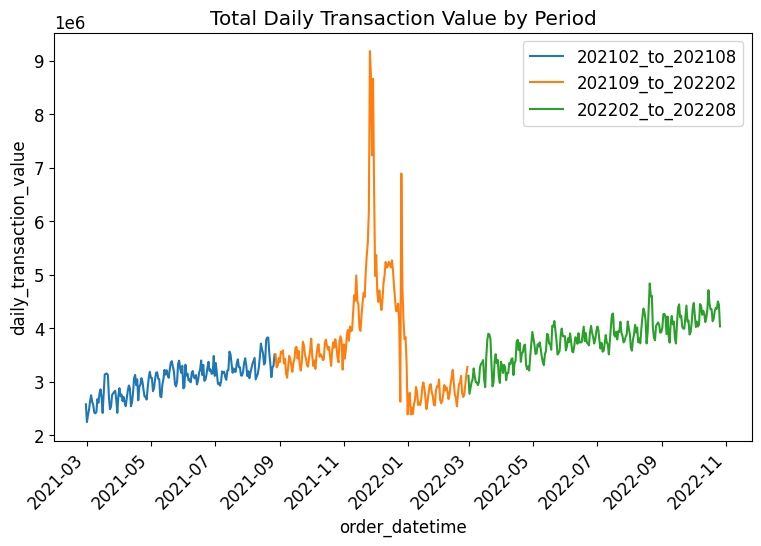

In [8]:
# checking for different regimes which may drive the "mixture model" observed in the prior section

# split the data into the 3 different subsets
transaction_daily = transaction_data.groupBy("order_datetime").agg(
    F.sum("dollar_value").alias("daily_value_traded"),
    F.count(F.col("order_datetime")).alias("num_daily_trades")
).toPandas()
transaction_daily["order_datetime"] = pd.to_datetime(transaction_daily["order_datetime"], format='%Y-%m-%d')
transaction_daily["202102_to_202108"] = transaction_daily.loc[transaction_daily["order_datetime"]<="2021-08-27","daily_value_traded"]
transaction_daily["202109_to_202202"] = transaction_daily.loc[(transaction_daily["order_datetime"]>"2021-08-27") & 
                                                              (transaction_daily["order_datetime"]<="2022-02-27"), "daily_value_traded"]
transaction_daily["202202_to_202208"] = transaction_daily.loc[transaction_daily["order_datetime"]>"2022-02-27","daily_value_traded"]

tr_plot = transaction_daily.plot(
    x="order_datetime", y=["202102_to_202108", "202109_to_202202", "202202_to_202208"],
    ylabel = "daily_transaction_value",
    title="Total Daily Transaction Value by Period",
    rot=45
)
fig = tr_plot.get_figure()
fig.set_size_inches(9, 6)
fig.savefig(f'{PLOTS}rev_segments.png', bbox_inches='tight')

print(f'number transactions Feb 2021 to Aug 2021: {transaction_daily.loc[transaction_daily["order_datetime"]<="2021-08-27","num_daily_trades"].sum()}')
print(f'number transactions Sep 2021 to Feb 2022: {transaction_daily.loc[(transaction_daily["order_datetime"]>"2021-08-27") & (transaction_daily["order_datetime"]<="2022-02-27"), "num_daily_trades"].sum()}')
print(f'number transactions Feb 2022 to Aug 2022: {transaction_daily.loc[transaction_daily["order_datetime"]>"2022-02-27","num_daily_trades"].sum()}')

del transaction_daily

It can be seen that the Sept 2021 to Feb 2022 contains a distinct transaction regime around Christmas time, when there is a substantial peak in transaction value and a lot of volatility in daily transaction value. It stands to reason that this period may involve a different fraud regime to the other two subsets (and there is no fraud data provided for Feb 2022 to Aug 2022). This is examined below. 

Total number of fraud obs in full dataset: 32710
Total number of fraud obs in subset: 3838


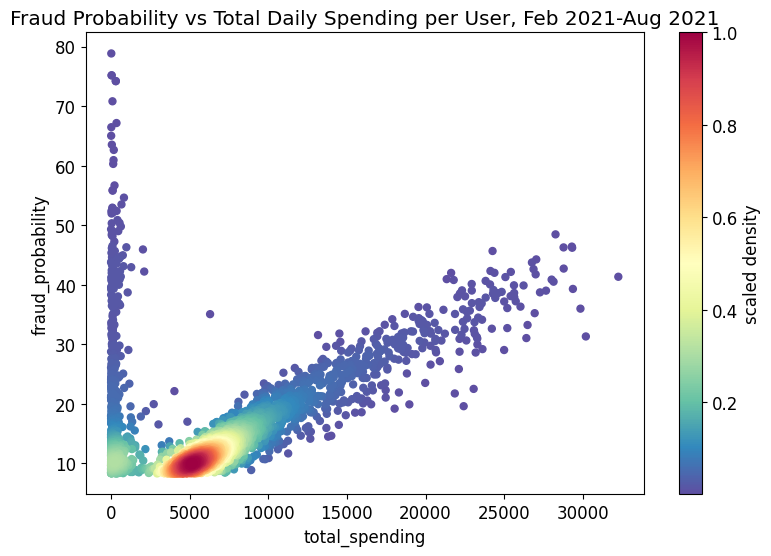

In [9]:
# check the relationship between transaction size and fraud for Feb 2021 to Aug 2021

print(f'Total number of fraud obs in full dataset: {consumer_fraud_daily.shape[0]}')
get_transactions = consumer_fraud_daily[(consumer_fraud_daily["order_datetime"]<='2021-8-27')]
print(f'Total number of fraud obs in subset: {get_transactions.shape[0]}')
scatter_subset = scatter_density(get_transactions, 'total_spending', 'fraud_probability', 'Fraud Probability vs Total Daily Spending per User, Feb 2021-Aug 2021')
scatter_subset.savefig(f'{PLOTS}fraud_scatter1.png', bbox_inches='tight')

Total number of fraud obs in full dataset: 32710
Total number of fraud obs in subset: 28872


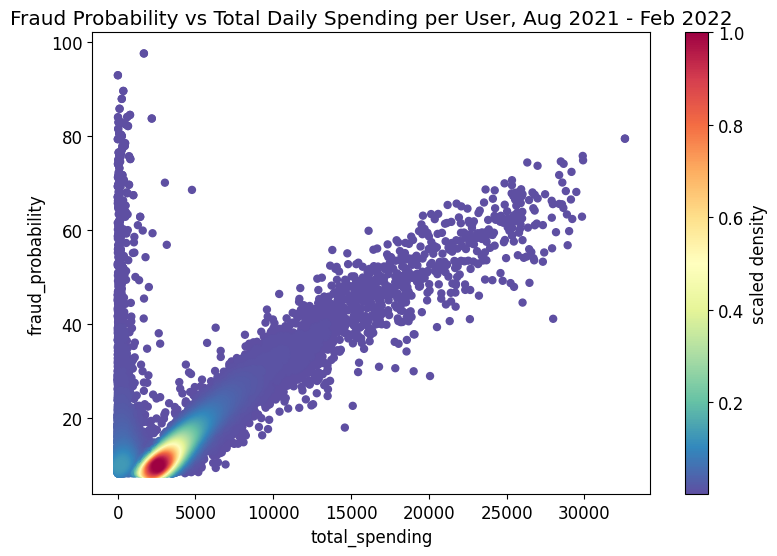

In [10]:
# check the relationship between transaction size and fraud for Aug 2021 to Feb 2022

print(f'Total number of fraud obs in full dataset: {consumer_fraud_daily.shape[0]}')
get_transactions = consumer_fraud_daily[(consumer_fraud_daily["order_datetime"]>'2021-8-27') &
                                        (consumer_fraud_daily["order_datetime"]<='2022-2-27')]
print(f'Total number of fraud obs in subset: {get_transactions.shape[0]}')
scatter_subset = scatter_density(get_transactions, 'total_spending', 'fraud_probability', 'Fraud Probability vs Total Daily Spending per User, Aug 2021 - Feb 2022')

It appears that there is indeed a difference of fraud regime for the Feb 2021-Aug 2021 data, versus the Aug 2021-Feb 2022. Further to this it seems apparent that for both subsets there is a different regime applied to small spend amounts versus large spend amounts (which looks like a strong linear relationship)

### Feb 2021 to Aug 2021 data

Total number of fraud obs in full dataset: 32710
Total number of fraud obs in subset: 885


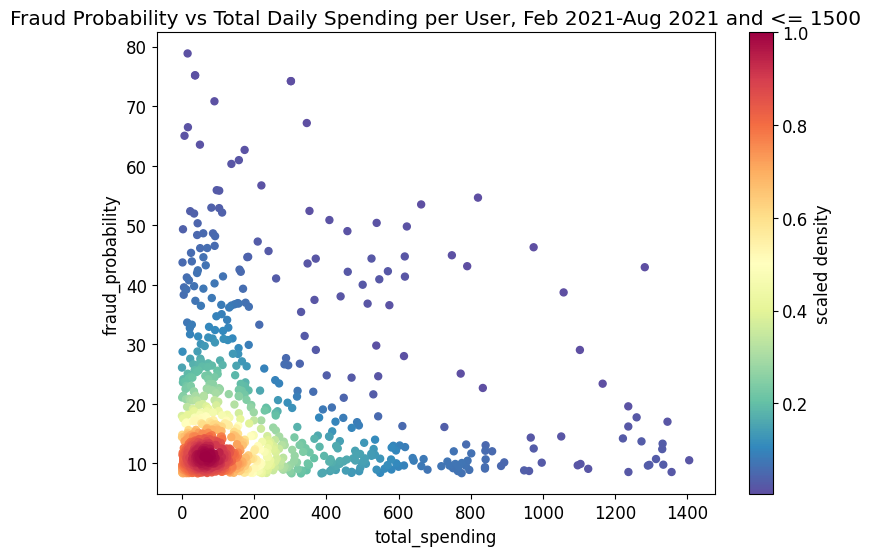

In [11]:
# we split the data into smaller than $1500 daily transaction, and greater than, Feb 2021-Aug 2021 data
print(f'Total number of fraud obs in full dataset: {consumer_fraud_daily.shape[0]}')
get_transactions = consumer_fraud_daily[(consumer_fraud_daily["order_datetime"]<='2021-8-27') &
                                        (consumer_fraud_daily["total_spending"]<=1500)]
print(f'Total number of fraud obs in subset: {get_transactions.shape[0]}')
scatter_subset = scatter_density(get_transactions, 'total_spending', 'fraud_probability', 'Fraud Probability vs Total Daily Spending per User, Feb 2021-Aug 2021 and <= 1500')

Total number of fraud obs in full dataset: 32710
Total number of fraud obs in subset: 2953


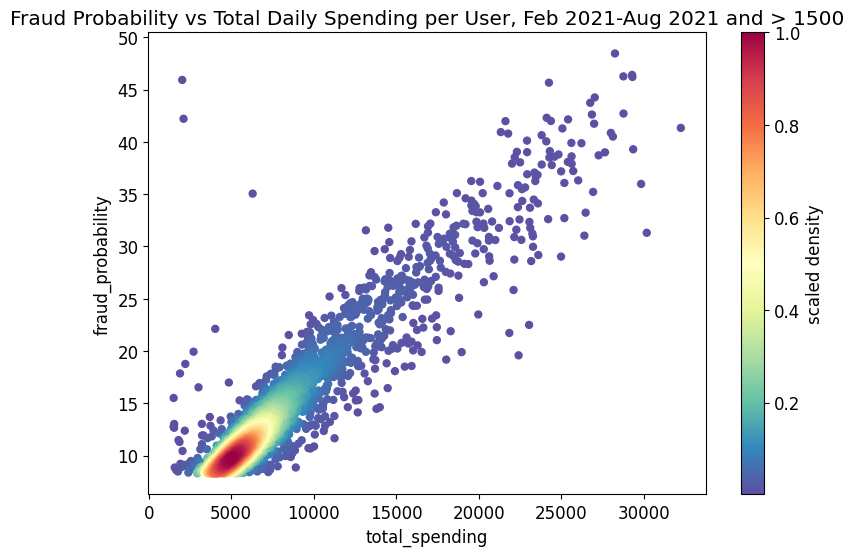

In [12]:
# we split the data into smaller than $1500 daily transaction, and greater than, Feb 2021-Aug 2021 data
print(f'Total number of fraud obs in full dataset: {consumer_fraud_daily.shape[0]}')
get_transactions = consumer_fraud_daily[(consumer_fraud_daily["order_datetime"]<='2021-8-27')  &
                                        (consumer_fraud_daily["total_spending"]>1500)]
print(f'Total number of fraud obs in subset: {get_transactions.shape[0]}')
scatter_subset = scatter_density(get_transactions, 'total_spending', 'fraud_probability', 'Fraud Probability vs Total Daily Spending per User, Feb 2021-Aug 2021 and > 1500')

### Aug 2021 to Feb 2022 data

Total number of fraud obs in full dataset: 32710
Total number of fraud obs in subset: 3911


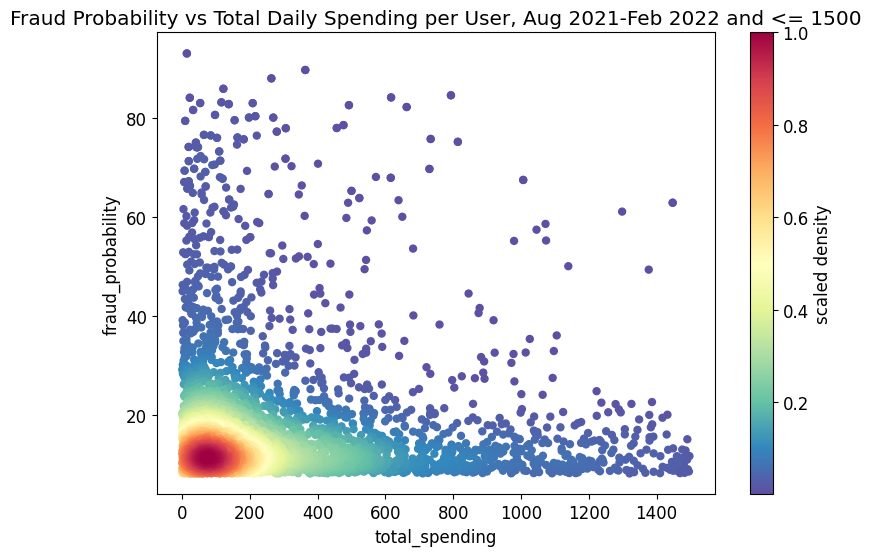

In [13]:
# we split the data into smaller than $1500 daily transaction, and greater than, Aug 2021-Feb 2022 data
print(f'Total number of fraud obs in full dataset: {consumer_fraud_daily.shape[0]}')
get_transactions = consumer_fraud_daily[(consumer_fraud_daily["order_datetime"]>'2021-8-27') &
                                        (consumer_fraud_daily["order_datetime"]<='2022-2-27') &
                                        (consumer_fraud_daily["total_spending"]<=1500)]
print(f'Total number of fraud obs in subset: {get_transactions.shape[0]}')
scatter_subset = scatter_density(get_transactions, 'total_spending', 'fraud_probability', 'Fraud Probability vs Total Daily Spending per User, Aug 2021-Feb 2022 and <= 1500')

Total number of fraud obs in full dataset: 32710
Total number of fraud obs in subset: 24961


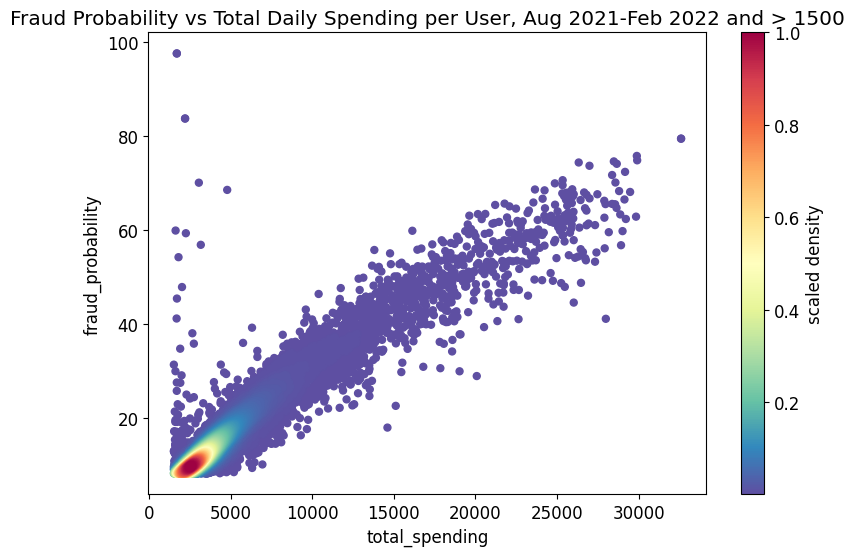

In [14]:
# we split the data into smaller than $1500 daily transaction, and greater than
print(f'Total number of fraud obs in full dataset: {consumer_fraud_daily.shape[0]}')
get_transactions = consumer_fraud_daily[(consumer_fraud_daily["order_datetime"]>'2021-8-27') &
                                        (consumer_fraud_daily["order_datetime"]<='2022-2-27') &
                                        (consumer_fraud_daily["total_spending"]>1500)]
print(f'Total number of fraud obs in subset: {get_transactions.shape[0]}')
scatter_subset = scatter_density(get_transactions, 'total_spending', 'fraud_probability', 'Fraud Probability vs Total Daily Spending per User, Aug 2021-Feb 2022 and > 1500')

It makes sense to fit separate models to total spending < 1500, and for total spending > 1500. As we are trying to fit the missing fraud data for the Feb 2022 to Aug 2022 period, and this period appears to match the spending regime for Feb 2021 to Aug 2021, we will use Feb 2021 to Aug 2021 as the training data.

### Fit the Feb 2021 to Aug 2021 data

First we fit the <1500 transaction value data

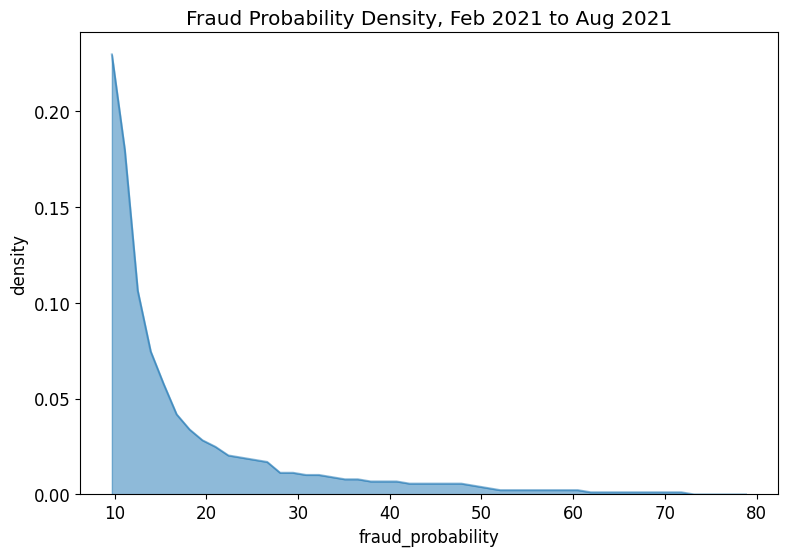

In [15]:
# first we model the <= 1500 total spending distribution
get_transactions = consumer_fraud_daily[(consumer_fraud_daily["order_datetime"]<='2021-8-27') &
                                        (consumer_fraud_daily["total_spending"]<=1500)]

# we examine the fraud probability distribution for this subset
freq_data = pd.DataFrame({'fraud_probability': pd.cut(get_transactions["fraud_probability"], 50, retbins=True)[1][1:],
                          'density': pd.cut(get_transactions["fraud_probability"], 50).value_counts().values})
freq_data["density"]=freq_data["density"]/sum(freq_data["density"])

# Plot the distribution of fraud probability
ax = freq_data.plot.area("fraud_probability", "density", stacked=False, title="Fraud Probability Density, Feb 2021 to Aug 2021", legend=False)
ax.set_ylabel("density")
fig = ax.get_figure()
fig.set_size_inches(9, 6)

#fig.savefig(f'{PLOTS}fraud_density_initial.png', bbox_inches='tight')


/home/mxp012/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


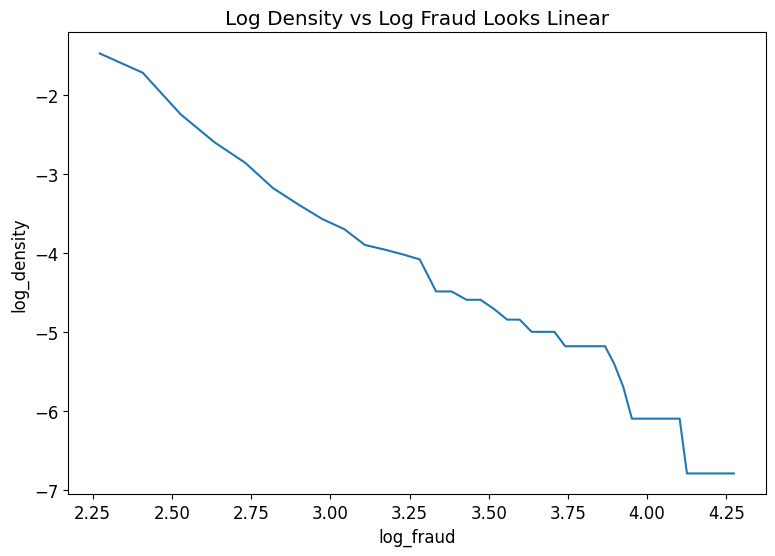

In [16]:
# it looks like a power law is involved so we take the log of predictor and response variables and plot
freq_data["log_fraud"] = np.log(freq_data["fraud_probability"])
freq_data["log_density"] = np.log(freq_data["density"])

ax = freq_data.plot("log_fraud", "log_density", title="Log Density vs Log Fraud Looks Linear", legend=False)
ax.set_ylabel("log_density")
fig = ax.get_figure()
fig.set_size_inches(9, 6)

#fig.savefig(f'{PLOTS}log_density.png', bbox_inches='tight')


The linear relationshiop between log density and log fraud, strongly suggests a power law would correctly model the distribution of user fraud

min fraud probability: 8.288894829411191


/tmp/ipykernel_138920/3066954702.py:24: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  leg.legendHandles[0].set_color('orange')


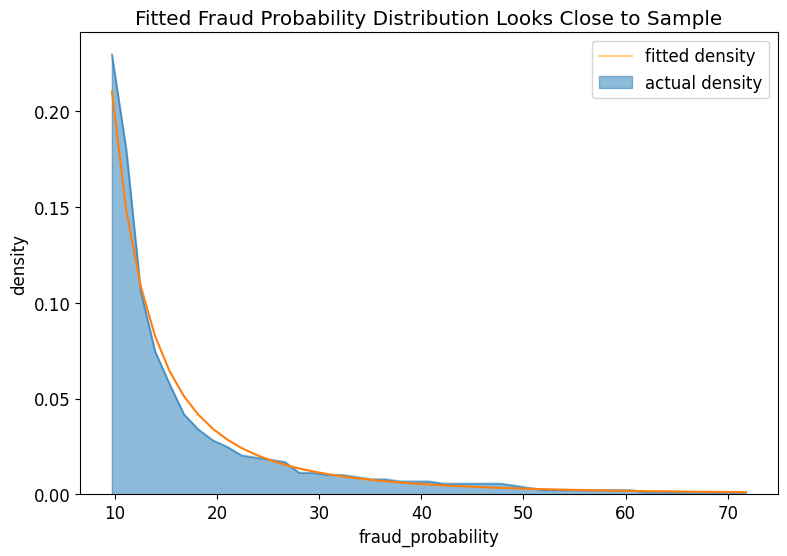

In [17]:
# fit a linear regression through the transformed data
freq_data = freq_data[freq_data["density"]>0]
fit_fraud_small = ols(
    formula="log_density ~ log_fraud",
    data=freq_data, missing="drop"
).fit()

# get the regression parameters
intercept = fit_fraud_small.params[0]
slope = fit_fraud_small.params[1]

# find floor of min fruad prob, and ceiling of max fraud prob, in the dataset
#print(f'min fraud probability: {np.floor(get_transactions["fraud_probability"].min())}')
#print(f'max fraud probability: {np.ceil(get_transactions["fraud_probability"].max())}')
min_fraud = get_transactions["fraud_probability"].min()
print(f'min fraud probability: {min_fraud}')

# plot the actual data versus fitted - looks like a good fit
ax = freq_data.plot.area("fraud_probability", "density", stacked=False, title = "Fitted Fraud Probability Distribution Looks Close to Sample", legend =False)
ax.plot(freq_data["fraud_probability"], freq_data["fraud_probability"]**slope*np.exp(intercept))
ax.set_ylabel("density")
ax.legend(["fitted density", "actual density"])
leg = ax.get_legend()
leg.legendHandles[0].set_color('orange')
fig = ax.get_figure()
fig.set_size_inches(9, 6)

fig.savefig(f'{PLOTS}fraud_density.png', bbox_inches='tight')

#del freq_data

In [18]:
# the fit has a good R^2
print(fit_fraud_small.summary())

                            OLS Regression Results                            
Dep. Variable:            log_density   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     1949.
Date:                Fri, 20 Oct 2023   Prob (F-statistic):           1.87e-37
Time:                        09:01:50   Log-Likelihood:                 6.7234
No. Observations:                  45   AIC:                            -9.447
Df Residuals:                      43   BIC:                            -5.834
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.3059      0.212     20.339      0.0

Note that the minimum fraud probability is 8.29%. We assume that fraud probability is actually generated in the range (fraud_min, 100), though anything lower than 8.29% is discarded as non-meaningful (most likely 8.29% is the quantile that relates to a particular cut-off point for the left-tail area of the distribution). fraud_min is some value close to zero, though not zero as the power law distribution gets asymptotic towards zero. We examine how the distribution of daily spend differs for transcations with and without fraud probability below

In [19]:
# aggregate daily spending by user
all_transactions = transaction_data.groupBy(["user_id", "order_datetime"]).agg(
    F.count(F.col("order_id")).alias("num_orders"),
    F.sum(F.col("dollar_value")).alias("total_spending")    
)

# pull in fraud data where available
all_transactions_fraud = all_transactions.join(consumer_fraud, on=["user_id", "order_datetime"], how="left")

percentage of aggregated daily user transactions with fraud probability: 0.16%


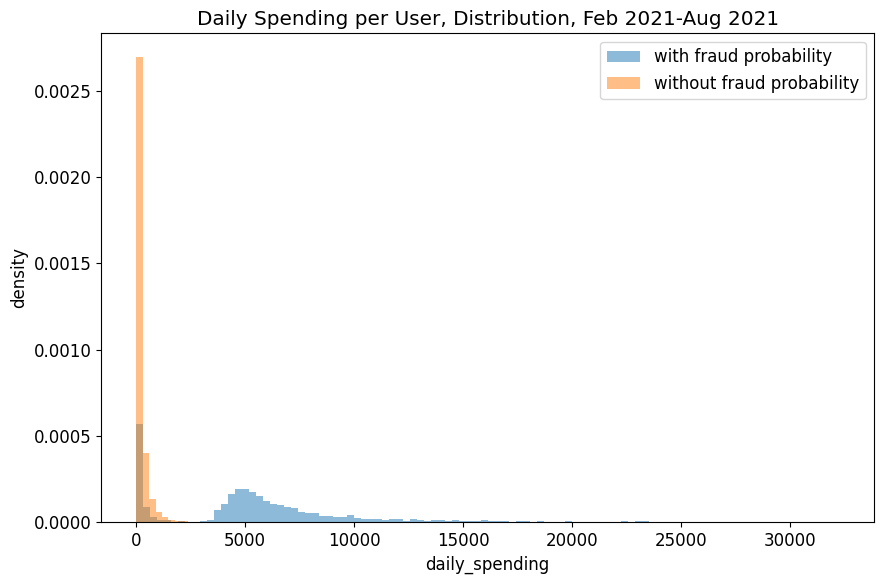

In [20]:
# extract pre Aug 2021 transactions 
subset_transactions = all_transactions_fraud.where(F.col('order_datetime')<=datetime.datetime(2021, 8, 27, 0, 0, 0))
subset_transactions = subset_transactions.toPandas()
subset_transactions["order_datetime"] = pd.to_datetime(subset_transactions["order_datetime"], format='%Y-%m-%d')

# only a minority of transactions have a fraud probability
fraud_num = sum(~subset_transactions["fraud_probability"].isnull())
sample_size = len(subset_transactions)
                
print(f'percentage of aggregated daily user transactions with fraud probability: {round(fraud_num/sample_size*100,2)}%')

all_trans = list(subset_transactions.loc[~subset_transactions["fraud_probability"].isnull(),"total_spending"])
all_fraud = list(subset_transactions.loc[~subset_transactions["fraud_probability"].isnull(),"fraud_probability"])
plt.figure(figsize=(9, 6))
plt.hist(all_trans, bins=100, alpha=0.5, label="with fraud probability", density=True)
plt.hist(list(subset_transactions.loc[subset_transactions["fraud_probability"].isnull(),"total_spending"]), 
         bins=100, alpha=0.5, label="without fraud probability", density=True)
plt.title('Daily Spending per User, Distribution, Feb 2021-Aug 2021')
plt.xlabel('daily_spending')
plt.ylabel('density')
plt.legend()
plt.tight_layout()
#plt.savefig(f'{PLOTS}fraud_density2.png', bbox_inches='tight')
plt.show()

del subset_transactions

First note that the transactions with a fraud probability follow two distinct distributions (explored in the revenue notebook), and that the transactions withouy a fraud probability appear to follow the first distribution at lower total spending levels. So it does support the view that transactions without a fraud probability are those that have been randomly sampled with a fraud probability < 8.29%

Now we want to run a sampling process on this regression to check that it mathches the original distribution. To do that we need to convert the log-linear regression back into the original space, and find the normalising constant and CDF function, and then invert it. Once inverted we can run a random uniform sample to generate a random sample from the fraud probability distribution. We assume the fraud probability minimum is 0.15%, and maximum is 80% 

$$
\begin{aligned}
let~x&=fraud~probability\in{(0.15,80)}\\
\alpha&=regression~slope~coefficient\\
\beta&=regression~intercept~coefficient\\
\xi&=normalisation~constant\\
then~f_x(x)&=x^{\alpha}e^{\beta}\\
\xi&=\int_{0.15}^{80}x^{\alpha}e^{\beta}dx\\
&=\frac{e^{\beta}}{\alpha+1}[x^{\alpha+1}]_{0.15}^{80}\\
&=\frac{e^{\beta}}{\alpha+1}[80^{\alpha+1}-0.15^{\alpha+1}]\\
\Rightarrow F_x(x)=y&=\int_{0.15}^{x}\frac{u^{\alpha}e^{\beta}}{\xi}du\\
&=\frac{e^{\beta}}{\xi(\alpha+1)}[u^{\alpha+1}]_{0.15}^{x}\\
&=\frac{e^{\beta}}{\xi(\alpha+1)}[x^{\alpha+1}-0.15^{\alpha+1}]\\
\Rightarrow x&=\biggl[\frac{y(\alpha+1)\xi}{e^{\beta}}+0.15^{\alpha+1}\biggl]^{1/\alpha+1}\\
\end{aligned}
$$

norm_constat: 941.9918032603971
percentage of aggregated daily user transactions with fraud probability: 0.17%


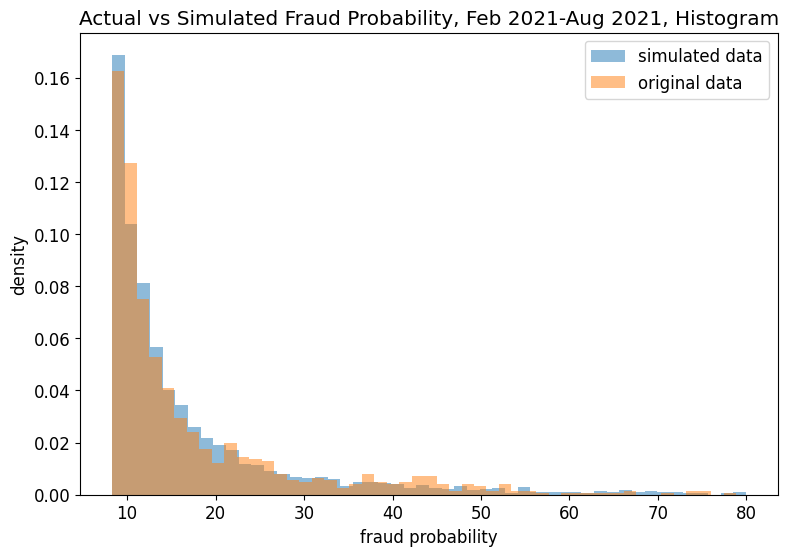

In [21]:
def sample_inversion(x: float, slope: float, intercept: float, norm_constant: float, min_fraud_prob: float) -> float:
    '''
    Helper function to invert a uniform sample to the fraud probability distribution
    Arguments: 
        - x = uniform sample
        - slope = slope term from log linear regeression
        - intercept = intercept term from log linear regeression
        - norm_constant = normalisation constant such that the distribution is a probability distribution
        - min_fraud_prob = minimum fraud probability that can be sampled
    Output: None
    '''
    return ((x*(slope+1)*norm_constant)/np.exp(intercept)+min_fraud_prob**(slope+1))**(1/(slope+1))

#min_fraud_prob = min_fraud
min_fraud_prob = 0.15
max_fraud_prob = 80

# calculate the normalisation constant
norm_constant = (max_fraud_prob**(slope+1)-min_fraud_prob**(slope+1))*np.exp(intercept)/(slope+1)
print(f'norm_constat: {norm_constant}')

# sample from the uniform normal distribution, with a sample size equivalent to all pre Aug 2021 daily user transactions,
# and invert to get fraud_probability distribution
sample = list(np.random.uniform(size=sample_size))
sample = [sample_inversion(x, slope, intercept, norm_constant, min_fraud_prob) for x in sample]
# discard all fraud probabilities less than 8.3%
sample = [x for x in sample if x >= min_fraud]
# number of transactions with fraud probability is similar to the original dataset
print(f'percentage of aggregated daily user transactions with fraud probability: {round(len(sample)/sample_size*100,2)}%')

# plot the results
plt.figure(figsize=(9, 6))
plt.hist(sample, bins=50, alpha=0.5, label="simulated data", density=True)
plt.hist(list(get_transactions["fraud_probability"]), bins=50, alpha=0.5, label="original data", density=True)
plt.title('Actual vs Simulated Fraud Probability, Feb 2021-Aug 2021, Histogram')
plt.xlabel('fraud probability')
plt.ylabel('density')
plt.legend()
plt.savefig(f'{PLOTS}simulation.png', bbox_inches='tight')
plt.show()



The 0.15 min fraud probability was found as a level that was reasonably close to zero, and gave a similar percentage of transactions with fraud probability, as the original data. The distribution looks good. 

We have successfully modelled the <1500 transaction value data, and will now run a linear regression on the >1500 transaction value data

In [22]:
get_transactions = consumer_fraud_daily[(consumer_fraud_daily["order_datetime"]<='2021-8-27') &
                                        (consumer_fraud_daily["total_spending"]>1500)]

# fit the linear regression and show the results
fit_fraud = ols(
    formula="fraud_probability ~ total_spending",
    data=get_transactions
).fit()

large_intercept = fit_fraud.params[0]
large_slope = fit_fraud.params[1]
# residual standard error is used for sampling from the regression
large_RSE = np.sqrt(fit_fraud.scale)

print(fit_fraud.summary())

                            OLS Regression Results                            
Dep. Variable:      fraud_probability   R-squared:                       0.874
Model:                            OLS   Adj. R-squared:                  0.874
Method:                 Least Squares   F-statistic:                 2.046e+04
Date:                Fri, 20 Oct 2023   Prob (F-statistic):               0.00
Time:                        09:02:09   Log-Likelihood:                -6740.4
No. Observations:                2953   AIC:                         1.348e+04
Df Residuals:                    2951   BIC:                         1.350e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          3.2864      0.085     38.

The R^2 value looks good. Now we can estimate fraud probability data for the Feb 2022 to Aug 2022 transaction dataset, where no fraud probability is currently assigned. 

### Estimate fraud probability data for Feb 2022 to Aug 2022

In [23]:
# get the post Feb 2022 transactions and split into transactions <1500 and >1500
subset_transactions = all_transactions.where(F.col('order_datetime')>datetime.datetime(2022, 2, 27, 0, 0, 0)).orderBy(F.col("total_spending"))
all_spending = np.array(subset_transactions.select("total_spending").collect()).reshape(-1)
small_transactions = all_spending[all_spending<=1500]
large_transactions = all_spending[all_spending>1500]

# generate the fraud probabilities for transactions <1500
np.random.seed(seed=123)
sample = list(np.random.uniform(size=len(small_transactions)))
sample = [sample_inversion(x, slope, intercept, norm_constant, min_fraud_prob) for x in sample]
sample = [x if x >= min_fraud else np.NaN for x in sample]
print(f'percentage of aggregated daily user small transactions with fraud probability: {round(np.sum(~np.isnan(sample))/len(small_transactions)*100,2)}%')

# generate the fraud probabilities for transactions >1500
predict_transactions = np.reshape(large_transactions, (-1,1))
predict_transactions = sm.add_constant(predict_transactions)
predict_transactions = pd.DataFrame(predict_transactions, columns=["Intercept", "total_spending"])
# include noise based on the RSE
np.random.seed(seed=456)
large_spend_fraud = fit_fraud.predict(predict_transactions) + np.random.normal(0,large_RSE,len(predict_transactions))
large_spend_fraud = list(large_spend_fraud)
large_spend_fraud = [x if x >= min_fraud else np.NaN for x in large_spend_fraud]

# combine the samples and extract the relevant user_id and order_datetime data
all_sample = sample + list(large_spend_fraud)
all_user_id = np.array(subset_transactions.select("user_id").collect()).reshape(-1)
keep_user_id = [user_id for user_id, fraud in zip(all_user_id, all_sample) if not(np.isnan(fraud))]
del all_user_id
all_order_datetime = np.array(subset_transactions.select("order_datetime").collect()).reshape(-1)
keep_order_datetime = [order_dt for order_dt, fraud in zip(all_order_datetime, all_sample) if not(np.isnan(fraud))]
del all_order_datetime
keep_sample = [fraud for fraud in all_sample if not(np.isnan(fraud))]



percentage of aggregated daily user small transactions with fraud probability: 0.17%


In [24]:
# combine the new fraud data with the existing data and save down for use in merchant revenue modelling

add_fraud_data = pd.DataFrame({"user_id": keep_user_id, "order_datetime": keep_order_datetime, "fraud_probability": keep_sample})
consumer_fraud = pd.read_pickle(f"{CURATED_DATA}consumer_fraud_probability.pkl")
print(f"records before adding new data: {len(consumer_fraud)}")
consumer_fraud = pd.concat([consumer_fraud, add_fraud_data])
print(f"records after adding new data: {len(consumer_fraud)}")
#consumer_fraud["order_datetime"] = pd.to_datetime(consumer_fraud["order_datetime"], format='%Y-%m-%d')
consumer_fraud.to_pickle(f"{CURATED_DATA}consumer_fraud_full.pkl")

records before adding new data: 34864
records after adding new data: 62448


### Examine the results

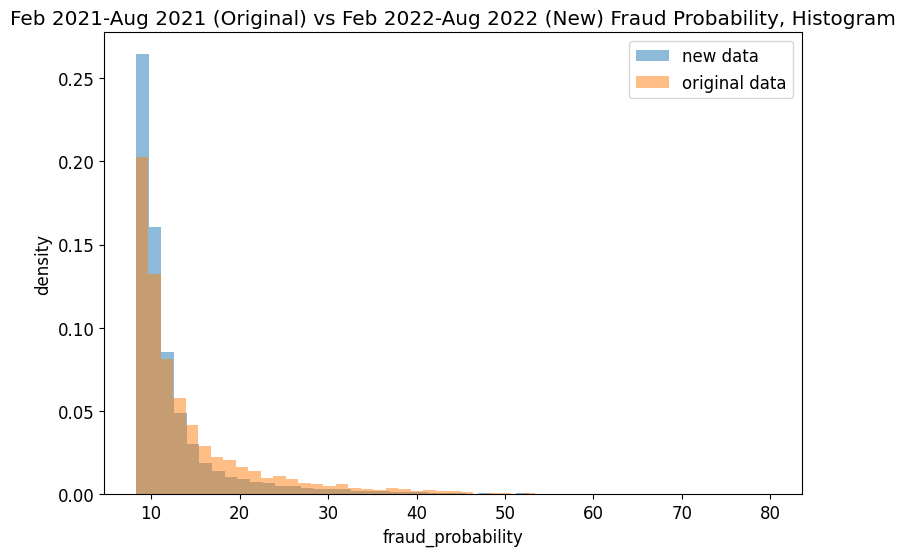

In [25]:
# compare to new fraud data distribution to the original dataset

plt.figure(figsize=(9, 6))
plt.hist(list(add_fraud_data["fraud_probability"]), bins=50, alpha=0.5, label="new data", density=True)
plt.hist(all_fraud, bins=50, alpha=0.5, label="original data", density=True)
plt.title('Feb 2021-Aug 2021 (Original) vs Feb 2022-Aug 2022 (New) Fraud Probability, Histogram')
plt.xlabel('fraud_probability')
plt.ylabel('density')
plt.legend()
#plt.savefig(f'{PLOTS}simulation2.png', bbox_inches='tight')
plt.show()

Looks like the new data has more density in lower fraud probability, lets see why

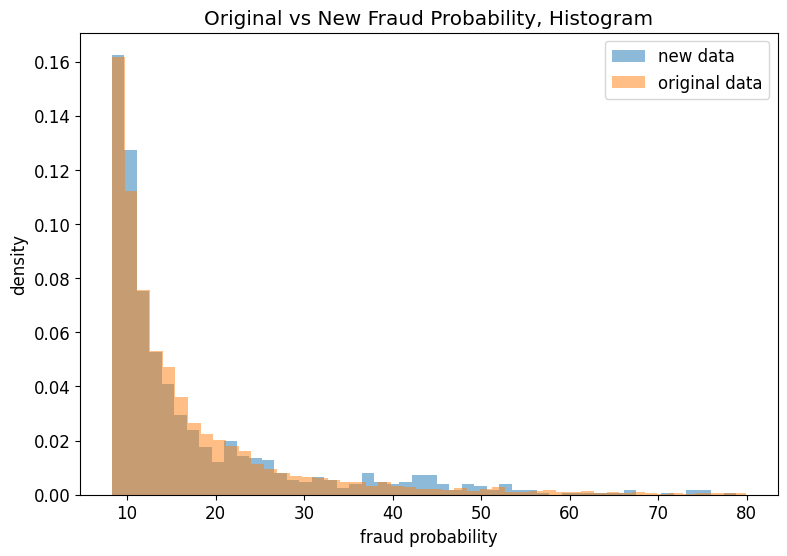

In [26]:
# compare the original and new fraud probability data, for small transactions

get_transactions = consumer_fraud_daily[(consumer_fraud_daily["order_datetime"]<='2021-8-27') &
                                        (consumer_fraud_daily["total_spending"]<=1500)]
plt.figure(figsize=(9, 6))
plt.hist(list(get_transactions["fraud_probability"]), bins=50, alpha=0.5, label="new data", density=True)
plt.hist(sample, bins=50, alpha=0.5, label="original data", density=True)
plt.title('Original vs New Fraud Probability, Histogram')
plt.xlabel('fraud probability')
plt.ylabel('density')
plt.legend()
plt.show()


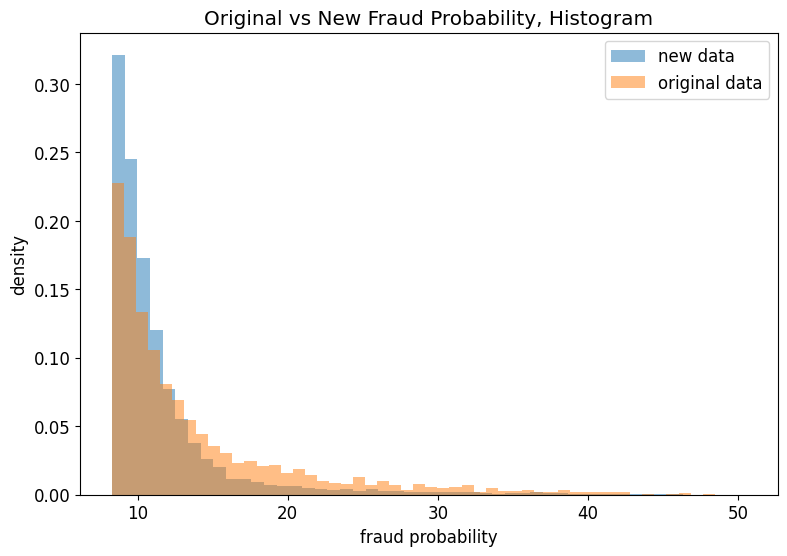

In [27]:
# compare the original and new fraud probability data, for large transactions

get_transactions = consumer_fraud_daily[(consumer_fraud_daily["order_datetime"]<='2021-8-27') &
                                        (consumer_fraud_daily["total_spending"]>1500)]
plt.figure(figsize=(9, 6))
plt.hist(large_spend_fraud, bins=50, alpha=0.5, label="new data", density=True)
plt.hist(list(get_transactions["fraud_probability"]), bins=50, alpha=0.5, label="original data", density=True)
plt.title('Original vs New Fraud Probability, Histogram')
plt.xlabel('fraud probability')
plt.ylabel('density')
plt.legend()
plt.show()

Lower transaction size fraud distribution looks the same, higher transaction size fraud disitrbution is driving the difference

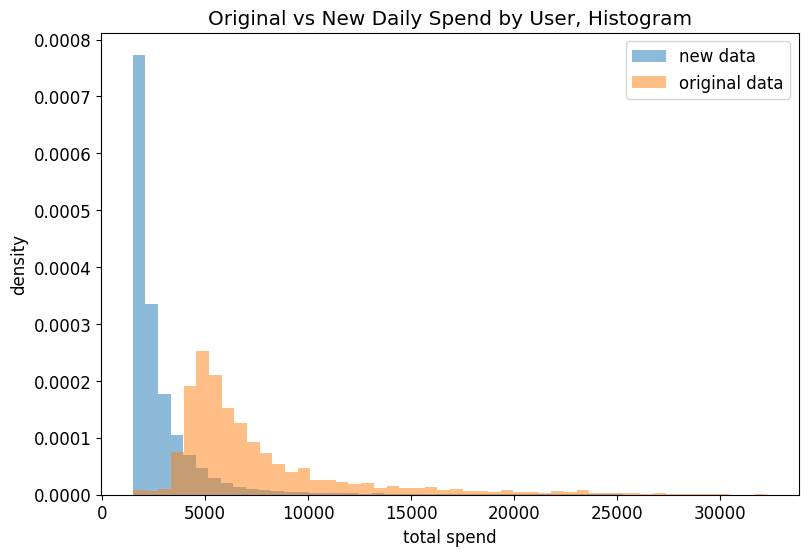

----------------------------------------
Exception occurred during processing of request from ('127.0.0.1', 51680)
Traceback (most recent call last):
  File "/usr/lib/python3.10/socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "/usr/lib/python3.10/socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "/usr/lib/python3.10/socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "/usr/lib/python3.10/socketserver.py", line 747, in __init__
    self.handle()
  File "/home/mxp012/.local/lib/python3.10/site-packages/pyspark/accumulators.py", line 281, in handle
    poll(accum_updates)
  File "/home/mxp012/.local/lib/python3.10/site-packages/pyspark/accumulators.py", line 253, in poll
    if func():
  File "/home/mxp012/.local/lib/python3.10/site-packages/pyspark/accumulators.py", line 257, in accum_updates
    num_updates = re

In [28]:
# plot the transaction distribution for large transactions, original vs new data
get_transactions = consumer_fraud_daily[(consumer_fraud_daily["order_datetime"]<='2021-8-27') &
                                        (consumer_fraud_daily["total_spending"]>1500)]
plt.figure(figsize=(9, 6))
plt.hist(large_transactions, bins=50, alpha=0.5, label="new data", density=True)
plt.hist(list(get_transactions["total_spending"]), bins=50, alpha=0.5, label="original data", density=True)
plt.title('Original vs New Daily Spend by User, Histogram')
plt.xlabel('total spend')
plt.ylabel('density')
plt.legend()
plt.show()

This is actually explained by the difference in distribution of larger transaction size spend, which has shifted to a lower level in the new data